In [94]:
import sys
import os
import time
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

In [46]:
def getData():
    comments = pd.read_csv('FilmWeb-detectingEmotions-lemmatisation.csv')
    comments.loc[comments.emotion == 'neutral', 'emotion'] = "negative"
    comments = comments.reset_index()    
    return comments

In [79]:
#split (0.8 train_data 0.2 test_data)
def prepereDataWithoutLemmatisation(split, comments):
    data = np.empty((0))
    data_labels = np.empty((0))

    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    length_train_data = int(split * len(comments))
    train_data = comments[:length_train_data]
    test_data = comments[length_train_data:]
  
    for index, train_data in train_data.iterrows():
        data = np.append(data, train_data['text'])
        data_labels = np.append(data_labels, train_data['emotion'])
    return [data, data_labels, test_data]

In [80]:
def SVM_liblinear(iterations, dataset, is_shuffle):
    data = dataset[0]
    data_labels = dataset[1]
    
    sss = StratifiedKFold(n_splits=iterations, shuffle=is_shuffle)

    for train_index, test_index in sss.split(data, data_labels):
        train_data = data[train_index]
        train_labels = data_labels[train_index]
        
        vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
        train_vectors = vectorizer.fit_transform(train_data)
        
        classifier_liblinear = svm.LinearSVC()
        classifier_liblinear.fit(train_vectors, train_labels)
        
    return [classifier_liblinear,vectorizer]

In [87]:
def SCV_detectingEmotions(classifier, vectorizer, test_data):
    test_vectors = vectorizer.transform(test_data)
    prediction_liblinear = classifier.predict(test_vectors)
    return prediction_liblinear

In [82]:
def createDataAfterClassifier(data, detectedEmotion):
    result_df = pd.DataFrame({"text": data['text'], "detectedEmotion": detectedEmotion, 'emotion': data['emotion']})
    return result_df

In [83]:
def get_length(text):
    return len(text)

def get_length_bin(length):
    return length / 10

def get_score(result):
    return 1 if result else 0

def prepereDataForPlot(result_df):
    result_df['correct_guess'] = result_df['detectedEmotion'] == result_df['emotion']
    result_df['score'] = map(get_score, result_df['correct_guess'])
    result_df['text_length'] = map(get_length, result_df['text'])
    #create group with 10 elements
    result_df['text_length_bin'] = map(get_length_bin, result_df['text_length'])    
    return result_df

In [84]:
def createPlot(data):
    grouped = data.groupby('text_length_bin', as_index=False)['score'].mean()
    fig, ax = plt.subplots()
    x = grouped.text_length_bin * 10
    y = grouped.score
    fit = np.polyfit(x, y, deg=1)
    ax.plot(x, fit[0] * x + fit[1], color='red')
    ax.scatter(x, y)

    fig.show()

In [85]:
def splitData(data, split):  
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    length_train_data = int(split * len(data))
    train_data = data[:length_train_data]
    test_data = data[length_train_data:]
    
    return [train_data, test_data]

In [ ]:
#testing dataset
data = getData()
dataset = prepereDataWithoutLemmatisation(0.8, data)
[classifier, vectorizer] = SVM_liblinear(10, dataset, True)
testData = dataset[2]
detectedEmotion = SCV_detectingEmotions(classifier,vectorizer,testData['text'])

result_df = pd.DataFrame({"text": testData['text'], "detectedEmotion": detectedEmotion, 'emotion': testData['emotion']})

In [89]:
result_df = prepereDataForPlot(result_df)

/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


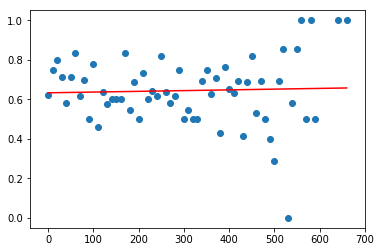

In [95]:
createPlot(result_df)